Fit linear models predicting female behavior from surrogate neural activity.

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import linear_model
import sys

from disp import set_plot
from my_torch import skl_fit_ridge

cc = np.concatenate


TARG_BHV = 'MTN'
TWDWS = [.03, 1, 60]
TARGS = [f'{TARG_BHV}_MN_{twdw}' for twdw in TWDWS]

PFX_BHV = f'data/simple/behav_xtd/behav_xtd'

BASES = ['rc', 'rect']
NH = 17  # num filter basis functions

COLS_USE = [f'S_{ch}' for ch in range(NH)] + [f'P_{ch}' for ch in range(NH)]

PTRAIN = .8
NSPLIT = 30

ALPHA = 10

NSPLIT_SAVE_Y_HAT = 5

MASK_PFX = 'data/simple/masks/mask'

if MASK_PFX:
    FSAVE_SFX = f'{TARG_BHV.lower()}_ridge_alpha_{ALPHA}_masked'
else:
    FSAVE_SFX = f'{TARG_BHV.lower()}_ridge_alpha_{ALPHA}'

In [2]:
STRAINS = ['NM91', 'ZH23']
STRAIN_KEY = '_'.join(STRAINS).lower()

FSTRAIN = 'data/simple/strains.csv'
MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

NTR = MSTRAIN.sum()
NTRAIN = int(round(PTRAIN*NTR))

In [3]:
for basis in BASES:
    pfx_nrl = f'data/simple/mlv/lin_filter/{basis}_lin/{basis}_lin'

    fsave = f'data/simple/mlv/lin_filter/{basis}_lin_{STRAIN_KEY}_{FSAVE_SFX}.npy'
    
    # fit regression models
    rslts = skl_fit_ridge(
        pfxs=[pfx_nrl, PFX_BHV],
        cols_x=COLS_USE,
        targs=TARGS,
        itr_all=ISTRAIN,
        ntrain=NTRAIN,
        nsplit=NSPLIT,
        mask_pfx=MASK_PFX,
        return_y=np.arange(NSPLIT_SAVE_Y_HAT),
        alpha=ALPHA)
    
    # save r2, weights, and example predictions
    save_data = {
        'r2_train': {targ: np.array([rslt.r2_train[targ] for rslt in rslts]) for targ in TARGS},
        'r2_test': {targ: np.array([rslt.r2_test[targ] for rslt in rslts]) for targ in TARGS},
        
        'w': {targ: np.array([rslt.w[targ] for rslt in rslts]) for targ in TARGS},
        'bias': {targ: np.array([rslt.bias[targ] for rslt in rslts]) for targ in TARGS},
        
        'ys_train': {targ: [rslt.ys_train[targ] for rslt in rslts if rslt.ys_train] for targ in TARGS},
        'ys_test': {targ: [rslt.ys_test[targ] for rslt in rslts if rslt.ys_train] for targ in TARGS},
        
        'y_hats_train': {targ: [rslt.y_hats_train[targ] for rslt in rslts if rslt.ys_train] for targ in TARGS},
        'y_hats_test': {targ: [rslt.y_hats_test[targ] for rslt in rslts if rslt.ys_train] for targ in TARGS},
        
        'targs': TARGS,
        'alpha': ALPHA,
        
        'ntr': NTR,
        'ntrain': NTRAIN,
        'nsplit': NSPLIT,
        
        'nr': len(COLS_USE),
    }

    np.save(fsave, np.array([save_data]))

Loading...

Split 0
Split 1
Split 2
Split 3
Split 4
Split 5
Split 6
Split 7
Split 8
Split 9
Split 10
Split 11
Split 12
Split 13
Split 14
Split 15
Split 16
Split 17
Split 18
Split 19
Split 20
Split 21
Split 22
Split 23
Split 24
Split 25
Split 26
Split 27
Split 28
Split 29Loading...

Split 0
Split 1
Split 2
Split 3
Split 4
Split 5
Split 6
Split 7
Split 8
Split 9
Split 10
Split 11
Split 12
Split 13
Split 14
Split 15
Split 16
Split 17
Split 18
Split 19
Split 20
Split 21
Split 22
Split 23
Split 24
Split 25
Split 26
Split 27
Split 28
Split 29

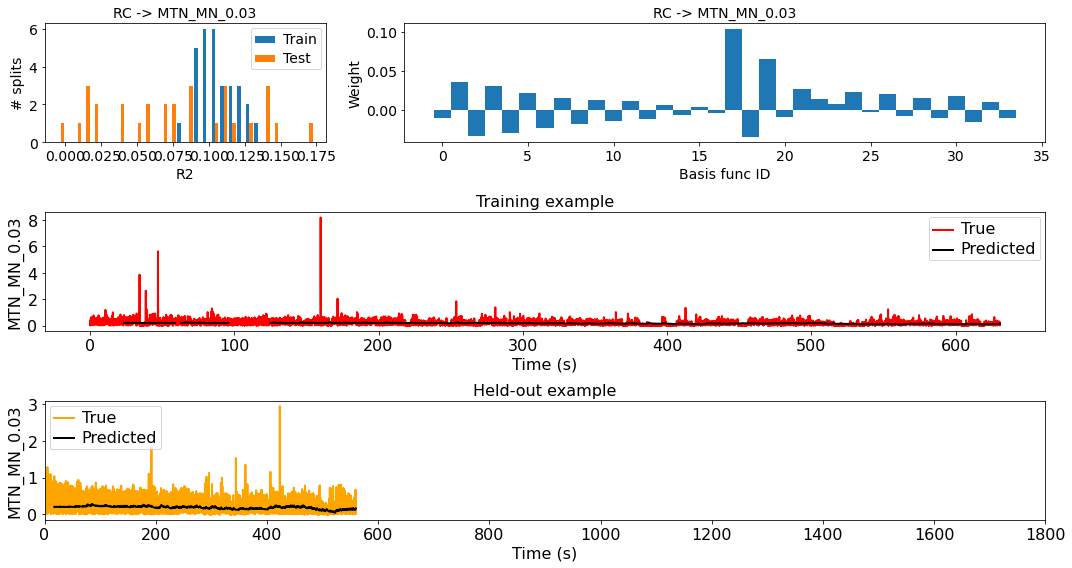

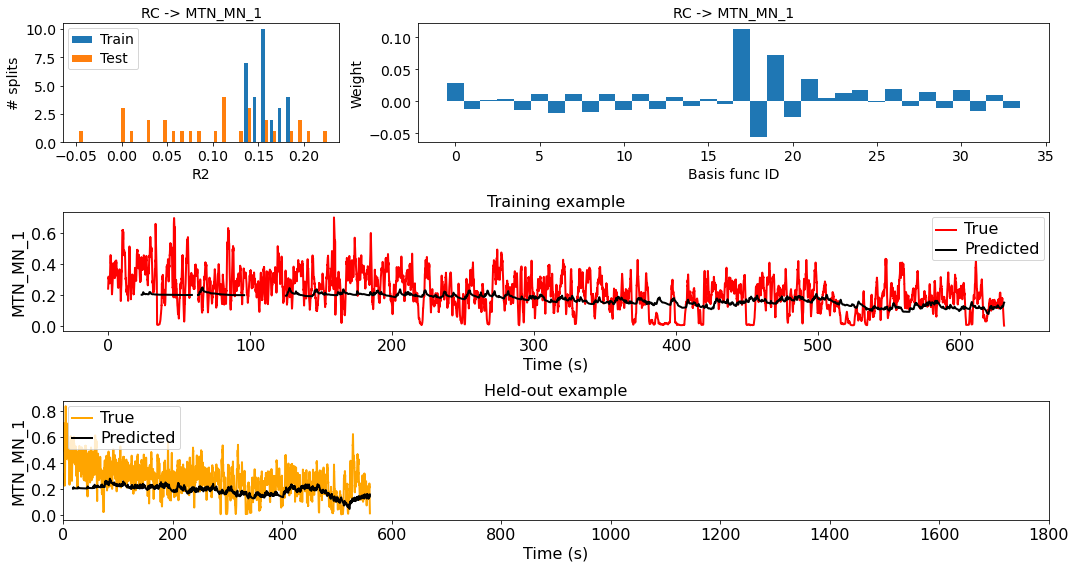

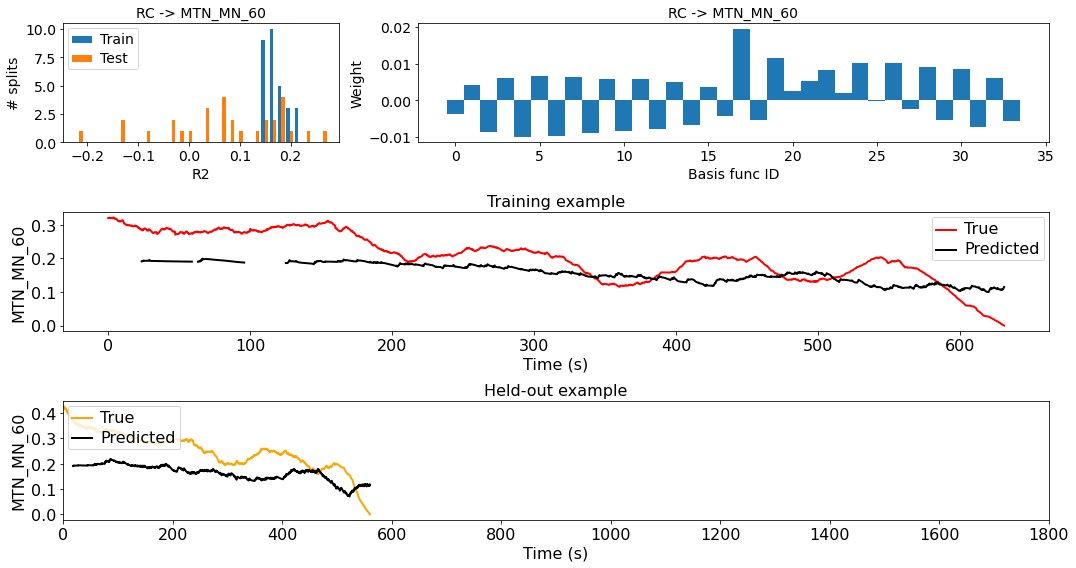

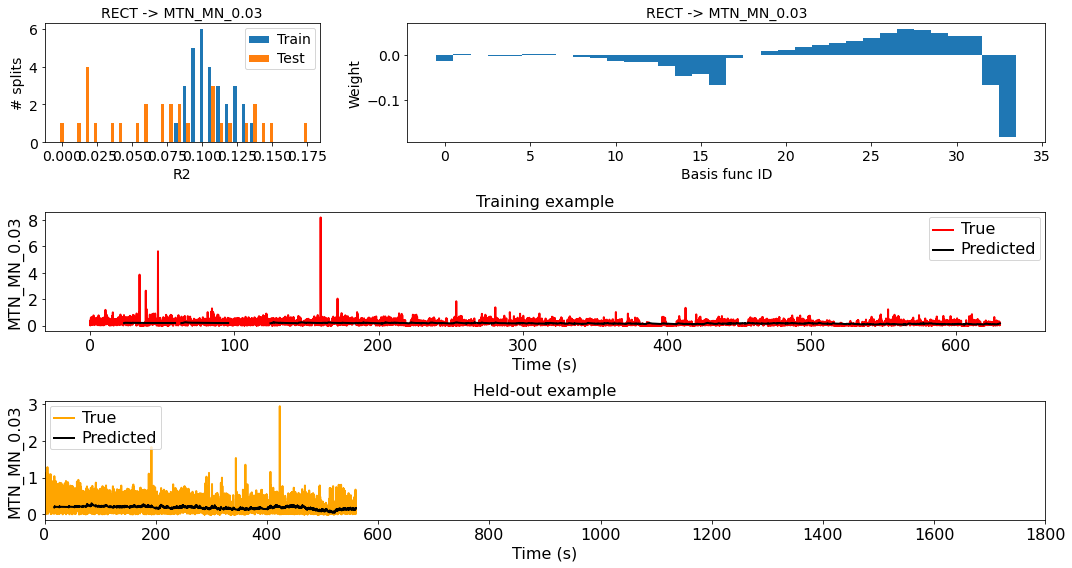

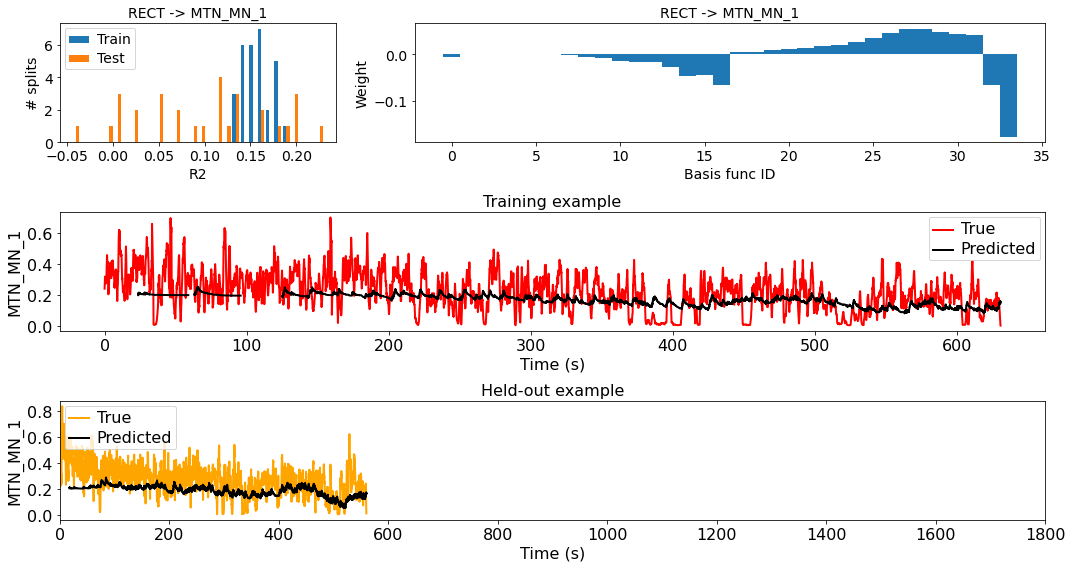

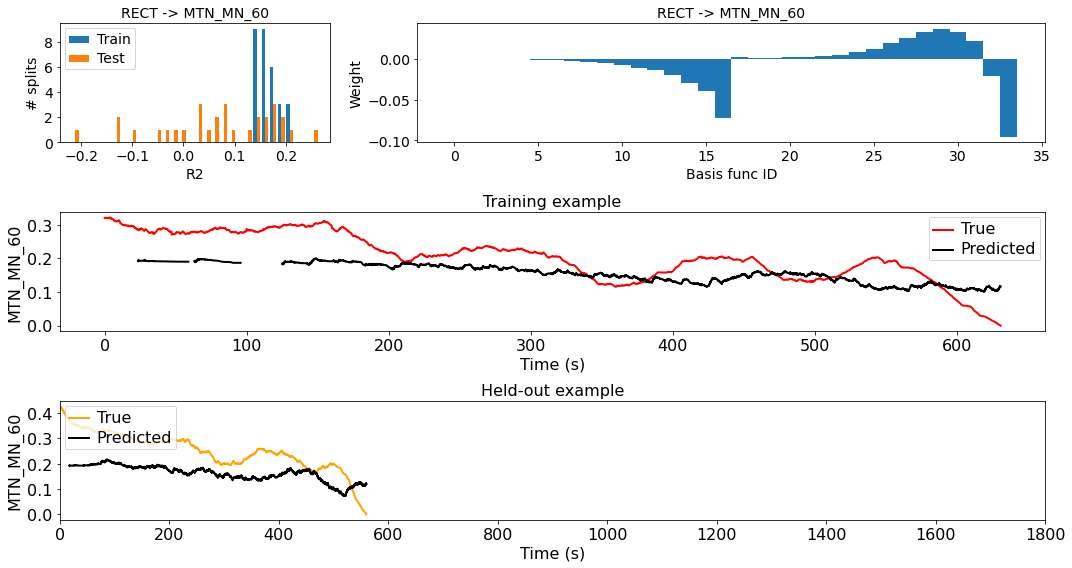

In [3]:
ISPLIT = 0
ITRAIN_PLOT = 1
ITEST_PLOT = 1

FPS = 30.03

for basis in BASES:
    fsave = f'data/simple/mlv/lin_filter/{basis}_lin_{STRAIN_KEY}_{FSAVE_SFX}.npy'
    
    data = np.load(fsave, allow_pickle=True)[0]

    for targ in TARGS:
        
        r2_train = data['r2_train'][targ]
        r2_test = data['r2_test'][targ]
        
        gs = gridspec.GridSpec(3, 3)

        fig = plt.figure(figsize=(15, 8), tight_layout=True)
        axs = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1:]), fig.add_subplot(gs[1, :]), fig.add_subplot(gs[2, :])]

        axs[0].hist(np.transpose([r2_train, r2_test]), bins=30)
        axs[0].legend(['Train', 'Test'])
        
        set_plot(axs[0], x_label='R2', y_label='# splits', title=f'{basis.upper()} -> {targ}', font_size=14)

        axs[1].bar(np.arange(data['w'][targ].shape[1]), np.mean(data['w'][targ], axis=0), width=1)
        set_plot(axs[1], x_label='Basis func ID', y_label='Weight', title=f'{basis.upper()} -> {targ}', font_size=14)

        y_train = data['ys_train'][targ][ISPLIT][ITRAIN_PLOT]
        t_train = np.arange(len(y_train))/FPS
        
        y_hat_train = data['y_hats_train'][targ][ISPLIT][ITRAIN_PLOT]
        
        axs[2].plot(t_train, y_train, c='r', lw=2)
        axs[2].plot(t_train, y_hat_train, c='k', lw=2)
        
        axs[2].legend(['True', 'Predicted'])
        
        set_plot(axs[2], x_label='Time (s)', y_label=targ, title='Training example', font_size=16)

        y_test = data['ys_test'][targ][ISPLIT][ITEST_PLOT]
        t_test = np.arange(len(y_test))/FPS
        
        y_hat_test = data['y_hats_test'][targ][ISPLIT][ITEST_PLOT]
        
        axs[3].plot(t_test, y_test, c='orange', lw=2)
        axs[3].plot(t_test, y_hat_test, c='k', lw=2)
        
        axs[3].legend(['True', 'Predicted'], loc='upper left')
        
        set_plot(axs[3], x_lim=(0, 1800), x_label='Time (s)', y_label=targ, title='Held-out example', font_size=16)

# Show filter reconstructions

In [4]:
FPS = 30.03
DT = 1/FPS
MAX_T = 120  # max look-back window
T_H = np.arange(0, MAX_T, DT)

17 filters


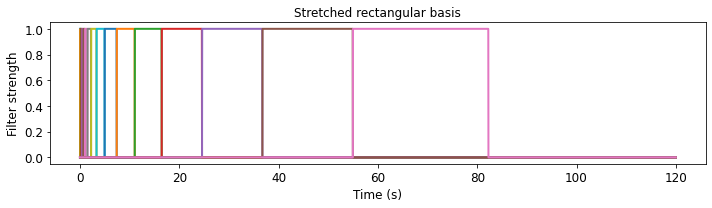

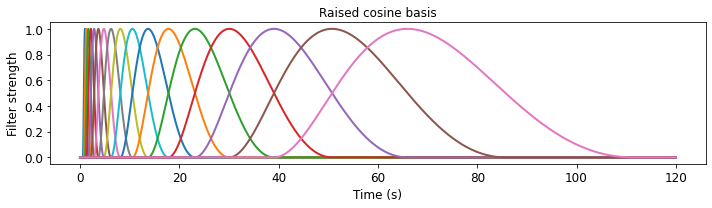

In [6]:
NDT_0 = 1  # width of closest filter
STRETCH = 1.5  # stretch factor relative to distance
hs_rect = []

istart = 0
istop = 0
ndt = NDT_0
while (istart+ndt)*DT < MAX_T:
    
    h_rect = np.zeros(T_H.shape)
    h_rect[istart:istart+ndt] = 1/(ndt*DT)
    hs_rect.append(h_rect.copy())
    
    istart = istart+ndt+1
    ndt = int(round(STRETCH*ndt))
    
hs_rect = np.array(hs_rect)

fig, ax = plt.subplots(1, 1, figsize=(10, 3), tight_layout=True)
for h_rect in hs_rect:
    ax.plot(T_H, h_rect/h_rect.max(), lw=2)
    
set_plot(ax, x_label='Time (s)', y_label='Filter strength', title='Stretched rectangular basis', font_size=12)
print(f'{len(hs_rect)} filters')

hs_rc = []
a = 6
c = 0
phis = np.arange(len(hs_rect)) * np.pi/2

for ch, phi in enumerate(phis):
    h_rc = .5*np.cos(a*np.log(T_H + c) - phi) + .5
    mt_zero = (a*np.log(T_H + c) < (phi-np.pi)) | (a*np.log(T_H + c) >= (phi+np.pi))
    h_rc[mt_zero] = 0
    hs_rc.append(h_rc)
    
hs_rc = np.array(hs_rc)
    
fig, ax = plt.subplots(1, 1, figsize=(10, 3), tight_layout=True)
for h_rc in hs_rc:
    ax.plot(T_H, h_rc/h_rc.max(), lw=2)
    
set_plot(ax, x_label='Time (s)', y_label='Filter strength', title='Raised cosine basis', font_size=12)

fig.savefig('supp/14_rc_lin_filter_basis.svg')

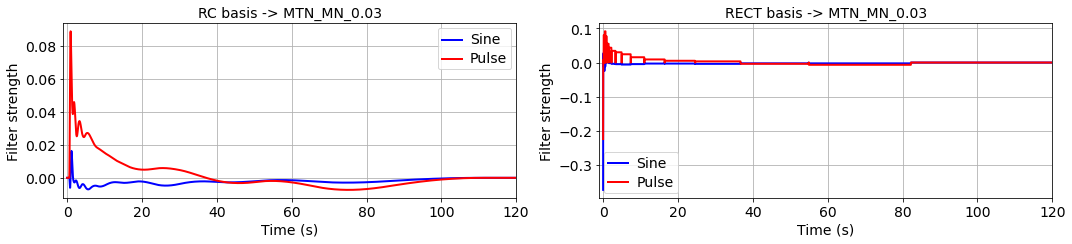

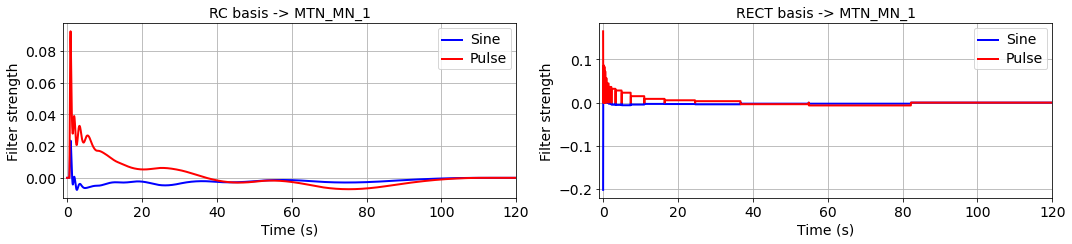

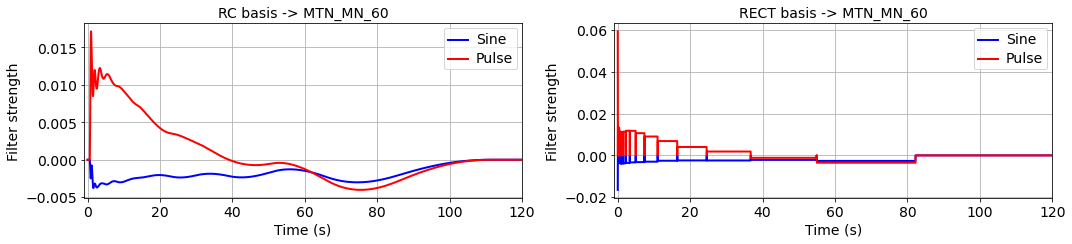

In [7]:
for twdw in TWDWS:
    targ = f'{TARG_BHV}_MN_{twdw}'
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 3.5), tight_layout=True)

    for ax, basis in zip(axs, BASES):
        fsave = f'data/simple/mlv/lin_filter/{basis}_lin_{STRAIN_KEY}_{FSAVE_SFX}.npy'
        data = np.load(fsave, allow_pickle=True)[0]
        
        if basis == 'rect':
            hs = hs_rect
        elif basis == 'rc':
            hs = hs_rc

        # sine filter
        w_s = data['w'][targ].mean(0)[:len(hs)]
        h_s = w_s@hs

        w_p = data['w'][targ].mean(0)[len(hs):]
        h_p = w_p@hs

        ax.plot(T_H, h_s, c='b', lw=2)
        ax.plot(T_H, h_p, c='r', lw=2)

        ax.set_xlim(-1, 120)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Filter strength')
        ax.legend(['Sine', 'Pulse'])
        
        ax.grid()
        
        set_plot(ax, title=f'{basis.upper()} basis -> {targ}', font_size=14)
        
    fig.savefig(f'supp/14_filter_twdw_{twdw}.svg')